In [78]:
import pandas as pd
import numpy as np
import os
import sys
import glob
import re
import json
import shutil
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.metrics import calculate_all_metrics, calculate_auprc, calculate_auroc

In [79]:
outputfolder_path_list = [
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output\20250522_182145_gpt4o",
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output\20250527_173753_llama3",
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\20250618_185435_gemini2p5_zhu_b_0shot_think",
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\20250617_214747_gemini2p5_zhu_b_0shot_0think",
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\20250617_215555_gemini2p5_sarvari_0shot_0think",
]

In [80]:
def categorize_files(outputfolder_path_list):
    """
    Categorize files in the output folders into metrics report files, metadata files, and log files.

    Args:
        outputfolder_path_list (list): List of output folder paths.

    Returns:
        dict: A dictionary containing categorized files.
    """
    file_list = []
    for outputfolder_path in outputfolder_path_list:
        file_list.extend(glob.glob(os.path.join(outputfolder_path, "*")))

    categorized_files = {
        "metrics_report_files": [f for f in file_list if "metrics_report" in f],
        "metadata_files": [f for f in file_list if "metadata" in f],
        "log_files": [f for f in file_list if "log" in f],
    }

    print("Metrics Report Files:")
    for file in categorized_files["metrics_report_files"]:
        print(file)
    print("\nMetadata Files:")
    for file in categorized_files["metadata_files"]:
        print(file)
    print("\nLog Files:")
    for file in categorized_files["log_files"]:
        print(file)

    return categorized_files
    

In [81]:
def load_metadata(metadata_path_list):
    """
    Load metadata from a CSV file into a DataFrame.
    
    Args:
        metadata_path (str): Path to the metadata CSV file.
        
    Returns:
        pd.DataFrame: DataFrame containing the metadata.
    """
    df_mdata = pd.DataFrame()
    for m_path in metadata_path_list:
        try:
            df = pd.read_csv(m_path)
            # Extract model name, task, dataset, and timestamp from the metadata path
            match = re.search(
                r"\\([^\\]+)_([^_]+)_([^_]+)_(\d{8}_\d{6})_metadata\.csv$", m_path
            )
            if match:
                model_name, task, dataset, timestamp = match.groups()
                print(f"Model Name: {model_name}, Task: {task}, Dataset: {dataset}, Timestamp: {timestamp}")
                # Add extracted metadata to the DataFrame
                df['model_name'] = model_name
                df['task'] = task
                df['dataset'] = dataset
                df['timestamp'] = timestamp

            else:
                print("Failed to extract metadata details from the path. Using default values.")
                df['model_name'] = "Unknown"
                df['task'] = "Unknown"
                df['dataset'] = "Unknown"
                df['timestamp'] = "Unknown"
            
            # Append the DataFrame to the main DataFrame
            df_mdata = pd.concat([df_mdata, df], ignore_index=True)

        except Exception as e:
            print(f"Error loading metadata: {e}")
            continue
    return df_mdata

In [82]:
def load_metrics_report_as_df(metrics_report_path):
    """
    Load metrics report from a JSON file and return it as a DataFrame.
    
    Args:
        metrics_report_path (str): Path to the metrics report JSON file.
        
    Returns:
        pd.DataFrame: DataFrame containing the metrics report.
    """
    try:
        with open(metrics_report_path, 'r') as f:
            metrics_report = json.load(f)
        df = pd.DataFrame(metrics_report)
        # Expand the metrics_summary dict into separate columns
        if "metrics_summary" in df.columns:
            metrics_expanded = df["metrics_summary"].apply(lambda x: x.get("overall", {}) if isinstance(x, dict) else {})
            metrics_df = pd.json_normalize(metrics_expanded)
            # Prefix columns with "metric_"
            metrics_df = metrics_df.add_prefix("metric_")
            df = pd.concat([df, metrics_df], axis=1)
            # Drop the original metrics_summary column
            df.drop(columns=["metrics_summary"], inplace=True)
        return df
    except Exception as e:
        print(f"Error loading metrics report: {e}")
        return None

In [83]:
def get_predictions_by_model_task_dataset(df, model, task, dataset):
    """
    Filter predictions DataFrame by model, task, and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df['model_name'] == model) & (df['task'] == task) & (df['dataset'] == dataset)]

In [84]:
def get_predictions_by_task_dataset(df, task, dataset):
    """
    Filter predictions DataFrame by task and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df["task"] == task) & (df["dataset"] == dataset)]

In [85]:
def get_predictions_by_model(df, model):
    """
    Filter predictions DataFrame by model.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[df["model_name"] == model]

In [109]:
def plot_metrics(df, titel_prefix=""):
    """
    Plot metrics from the DataFrame, grouped by model.

    Args:
        df (DataFrame): DataFrame containing metrics.
        titel_prefix (str): Prefix for the plot title.
    """
    if df.empty:
        print("No data to plot.")
        return

    metrics = ["metric_auprc", "metric_auroc", "metric_mcc"]
    metric_labels = ["AUPRC", "AUROC", "MCC"]

    # Prepare data for plotting
    plot_data = []
    for idx, row in df.iterrows():
        for metric, label in zip(metrics, metric_labels):
            if metric in df.columns:
                plot_data.append({
                    "Model": row.get("model_id", f"Model{idx}"),
                    "Metric": label,
                    "Value": row[metric]
                })

    plot_df = pd.DataFrame(plot_data)

    # Pivot so each model is a group, each metric is a bar
    pivot_df = plot_df.pivot(index="Model", columns="Metric", values="Value")

    ax = pivot_df.plot(kind="bar", figsize=(4, 4), width=0.5, edgecolor='black', colormap='Set1')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f"{titel_prefix}Metrics")
    plt.xlabel("Model")
    plt.ylabel("Value")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha='right')
    plt.legend(metric_labels, frameon=False)
    plt.tight_layout()
    plt.show()

In [87]:
cat_files = categorize_files(outputfolder_path_list)

Metrics Report Files:
C:\Users\janbe\Documents\GitHub Repos\pulse\output\20250522_182145_gpt4o\GPT4oModel_metrics_report.json
C:\Users\janbe\Documents\GitHub Repos\pulse\output\20250527_173753_llama3\Llama3Model_metrics_report.json
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\20250618_185435_gemini2p5_zhu_b_0shot_think\Gemini2p5flash_metrics_report.json
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\20250617_214747_gemini2p5_zhu_b_0shot_0think\Gemini2p5flash_metrics_report.json
C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\20250617_215555_gemini2p5_sarvari_0shot_0think\Gemini2p5flash_metrics_report.json

Metadata Files:
C:\Users\janbe\Documents\GitHub Repos\pulse\output\20250522_182145_gpt4o\GPT4oModel_mortality_hirid_20250522_182145_metadata.csv
C:\Users\janbe\Documents\GitHub Repos\pulse\output\20250527_173753_llama3\Llama3Model_aki_miiv_20250527_173753_metadata.csv
C:\Users\janbe\Documents\GitHub Repos\pulse\output\20250527_173753_llama3\Llama3

In [88]:
df_metadata = load_metadata(cat_files["metadata_files"])

Model Name: GPT4oModel, Task: mortality, Dataset: hirid, Timestamp: 20250522_182145
Model Name: Llama3Model, Task: aki, Dataset: miiv, Timestamp: 20250527_173753
Model Name: Llama3Model, Task: mortality, Dataset: miiv, Timestamp: 20250527_173753
Model Name: Llama3Model, Task: sepsis, Dataset: miiv, Timestamp: 20250527_173753


Model Name: Gemini2p5flash, Task: mortality, Dataset: eicu, Timestamp: 20250618_185435
Model Name: Gemini2p5flash, Task: mortality, Dataset: eicu, Timestamp: 20250617_214747
Model Name: Gemini2p5flash, Task: aki, Dataset: eicu, Timestamp: 20250617_215555
Model Name: Gemini2p5flash, Task: mortality, Dataset: eicu, Timestamp: 20250617_215555


In [89]:
df_metadata.tail(20)

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Inference Time,Input Tokens,Output Tokens,model_name,task,dataset,timestamp,Tokenization Time,Thinking Tokens,Thinking Output
802,Suggest a diagnosis of mortality for the follo...,0,0.10,not-mortality,Patient is 87 years old. While age is a risk f...,1.812396,2179,175,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
803,Suggest a diagnosis of mortality for the follo...,0,0.75,mortality,This 79-year-old male patient presents with se...,2.246556,2175,234,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
804,Suggest a diagnosis of mortality for the follo...,0,0.85,mortality,This 90-year-old male patient exhibits several...,1.975699,2182,199,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
805,Suggest a diagnosis of mortality for the follo...,0,0.75,mortality,This 52-year-old male patient exhibits several...,2.055940,2177,220,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
806,Suggest a diagnosis of mortality for the follo...,0,0.85,mortality,This 64-year-old female patient exhibits sever...,2.515168,2182,279,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
807,Suggest a diagnosis of mortality for the follo...,0,0.85,mortality,This 31-year-old male patient exhibits several...,2.375951,2181,301,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
808,Suggest a diagnosis of mortality for the follo...,0,0.15,not-mortality,"The patient is 90 years old, which is a risk f...",1.591724,2180,163,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
809,Suggest a diagnosis of mortality for the follo...,0,0.20,not-mortality,The patient exhibits several concerning marker...,1.957049,2175,203,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
810,Suggest a diagnosis of mortality for the follo...,0,0.75,mortality,This 53-year-old male patient presents with se...,2.593230,2184,298,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
811,Suggest a diagnosis of mortality for the follo...,0,0.15,not-mortality,The patient's vital signs and lab values are l...,2.438124,2181,267,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN


### Gemini 2.5 flash - Thinking

In [90]:
gemini_metrics_path = cat_files["metrics_report_files"][2]
gemini_metrics_path

'C:\\Users\\janbe\\Documents\\GitHub Repos\\pulse\\output_to_keep\\20250618_185435_gemini2p5_zhu_b_0shot_think\\Gemini2p5flash_metrics_report.json'

In [91]:
df_gemini2p5 = get_predictions_by_model(df_metadata, "Gemini2p5flash")
df_gemini2p5.head()

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Inference Time,Input Tokens,Output Tokens,model_name,task,dataset,timestamp,Tokenization Time,Thinking Tokens,Thinking Output
22,You are an experienced doctor in Intensive Car...,0,0.88,mortality,Elderly patient presenting with severe coagulo...,25.526863,10260,114,Gemini2p5flash,mortality,eicu,20250618_185435,0.0,3047.0,"Okay, here's my assessment. The patient is a 7..."
23,You are an experienced doctor in Intensive Car...,0,0.25,not-mortality,Patient presents with significant systemic inf...,33.435938,10283,154,Gemini2p5flash,mortality,eicu,20250618_185435,0.0,3396.0,"Okay, let's break this down. I've been asked t..."
24,You are an experienced doctor in Intensive Car...,0,0.82,mortality,Severe multi-organ dysfunction including profo...,39.501909,10230,155,Gemini2p5flash,mortality,eicu,20250618_185435,0.0,4627.0,"Alright, I've got the data and I'm ready to pu..."
25,You are an experienced doctor in Intensive Car...,0,0.78,mortality,The patient exhibits severe systemic inflammat...,29.333351,10253,157,Gemini2p5flash,mortality,eicu,20250618_185435,0.0,3506.0,"Alright, I've been asked to analyze this patie..."
26,You are an experienced doctor in Intensive Car...,0,0.90,mortality,Severe respiratory failure characterized by si...,29.767581,10235,177,Gemini2p5flash,mortality,eicu,20250618_185435,0.0,2776.0,"Okay, here's how I'm seeing this, as an experi..."


In [92]:
counter = 0
# Check for probability < 0.5 and "not" not in diagnosis
mask_low = df_gemini2p5["Predicted Probability"] < 0.5
for diag in df_gemini2p5.loc[mask_low, "Predicted Diagnosis"]:
    if "not" not in diag:
        counter += 1
# Check for probability > 0.5 and "not" not in diagnosis
mask_high = df_gemini2p5["Predicted Probability"] > 0.5
for diag in df_gemini2p5.loc[mask_high, "Predicted Diagnosis"]:
    if "not" in diag:
        counter += 1

print(
    f"{counter}/{len(df_gemini2p5)} predictions are inconsistent with the probability."
)

1/800 predictions are inconsistent with the probability.


Metrics per task / dataset

In [93]:
df_gemini2p5_metrics = load_metrics_report_as_df(gemini_metrics_path)
df_gemini2p5_metrics

,model_id,task_id,dataset,run_id,metric_auroc,metric_auprc,metric_normalized_auprc,metric_specificity,metric_f1_score,metric_accuracy,metric_balanced_accuracy,metric_precision,metric_recall,metric_mcc,metric_kappa,metric_minpse
0,Gemini2p5flash,mortality,eicu,20250618_185435,0.733,0.263,3.763,0.108,0.144,0.17,0.554,0.078,1.0,0.091,0.017,0.174


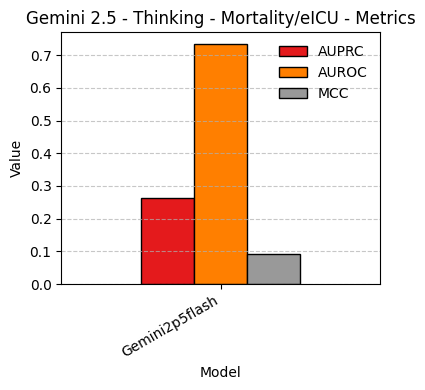

In [ ]:
plot_metrics(df_gemini2p5_metrics, "Reasoning - Mortality/eICU - ")

### Gemini 2.5 flash - No Reasoning

In [95]:
gemini_metrics_path_zhub = cat_files["metrics_report_files"][3]
gemini_metrics_path_zhub

'C:\\Users\\janbe\\Documents\\GitHub Repos\\pulse\\output_to_keep\\20250617_214747_gemini2p5_zhu_b_0shot_0think\\Gemini2p5flash_metrics_report.json'

In [96]:
df_gemini2p5 = get_predictions_by_model(df_metadata, "Gemini2p5flash")
df_gemini2p5 = df_gemini2p5[df_gemini2p5["Thinking Tokens"].isna()]
df_gemini2p5

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Inference Time,Input Tokens,Output Tokens,model_name,task,dataset,timestamp,Tokenization Time,Thinking Tokens,Thinking Output
122,You are an experienced doctor in Intensive Car...,0,0.25,not-mortality,"The patient's vital signs, while initially con...",2.298295,10260,151,Gemini2p5flash,mortality,eicu,20250617_214747,0.0,NaN,NaN
123,You are an experienced doctor in Intensive Car...,0,0.10,not-mortality,"The patient's vital signs and lab values, whil...",1.445528,10283,104,Gemini2p5flash,mortality,eicu,20250617_214747,0.0,NaN,NaN
124,You are an experienced doctor in Intensive Car...,0,0.10,not-mortality,The patient's lactate levels show a significan...,1.787478,10230,138,Gemini2p5flash,mortality,eicu,20250617_214747,0.0,NaN,NaN
125,You are an experienced doctor in Intensive Car...,0,0.10,not-mortality,The patient's vital signs and lab values are l...,1.599213,10253,118,Gemini2p5flash,mortality,eicu,20250617_214747,0.0,NaN,NaN
126,You are an experienced doctor in Intensive Car...,0,0.20,not-mortality,The patient shows improving trends in several ...,2.163999,10235,161,Gemini2p5flash,mortality,eicu,20250617_214747,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,Suggest a diagnosis of mortality for the follo...,0,0.75,mortality,This 59-year-old male patient exhibits several...,2.162554,2174,216,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
818,Suggest a diagnosis of mortality for the follo...,0,0.85,mortality,This 59-year-old male patient exhibits several...,2.641624,2179,298,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
819,Suggest a diagnosis of mortality for the follo...,0,0.75,mortality,This 71-year-old male patient exhibits several...,2.897877,2182,265,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN
820,Suggest a diagnosis of mortality for the follo...,0,0.85,mortality,This 58-year-old male patient presents with se...,1.975219,2182,243,Gemini2p5flash,mortality,eicu,20250617_215555,0.0,NaN,NaN


In [97]:
counter = 0
# Check for probability < 0.5 and "not" not in diagnosis
mask_low = df_gemini2p5["Predicted Probability"] < 0.5
for diag in df_gemini2p5.loc[mask_low, "Predicted Diagnosis"]:
    if "not" not in diag:
        counter += 1
# Check for probability > 0.5 and "not" not in diagnosis
mask_high = df_gemini2p5["Predicted Probability"] > 0.5
for diag in df_gemini2p5.loc[mask_high, "Predicted Diagnosis"]:
    if "not" in diag:
        counter += 1

print(
    f"{counter}/{len(df_gemini2p5)} predictions are inconsistent with the probability."
)

0/700 predictions are inconsistent with the probability.


Metrics per task / dataset

In [98]:
df_gemini2p5_metrics = load_metrics_report_as_df(gemini_metrics_path_zhub)
df_gemini2p5_metrics

,model_id,task_id,dataset,run_id,metric_auroc,metric_auprc,metric_normalized_auprc,metric_specificity,metric_f1_score,metric_accuracy,metric_balanced_accuracy,metric_precision,metric_recall,metric_mcc,metric_kappa,metric_minpse
0,Gemini2p5flash,mortality,eicu,20250617_214747,0.83,0.389,5.56,0.731,0.27,0.73,0.723,0.167,0.714,0.248,0.177,0.3


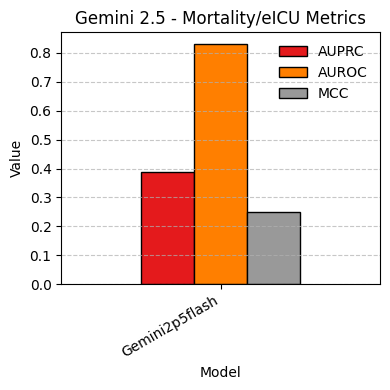

In [99]:
plot_metrics(df_gemini2p5_metrics, "Gemini 2.5 - Mortality/eICU ")

In [106]:
#Sarvari 
df_gemini2p5_metrics = load_metrics_report_as_df(cat_files["metrics_report_files"][4])
df_gemini2p5_metrics

,model_id,task_id,dataset,run_id,metric_auroc,metric_auprc,metric_normalized_auprc,metric_specificity,metric_f1_score,metric_accuracy,metric_balanced_accuracy,metric_precision,metric_recall,metric_mcc,metric_kappa,metric_minpse
0,Gemini2p5flash,mortality,eicu,20250617_215555,0.575,0.283,4.049,0.398,0.147,0.420,0.556,0.082,0.714,0.059,0.025,0.103
1,Gemini2p5flash,aki,eicu,20250617_215555,0.539,0.499,1.205,0.870,0.293,0.594,0.537,0.525,0.203,0.098,0.080,0.438


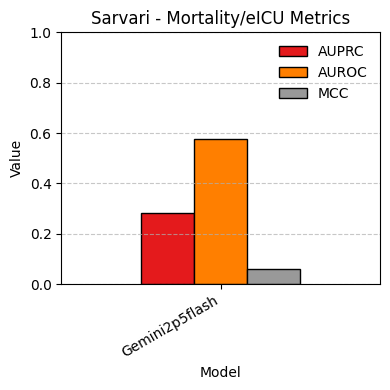

In [111]:
plot_metrics(df_gemini2p5_metrics.iloc[[0], :], "Sarvari - Mortality/eICU ")

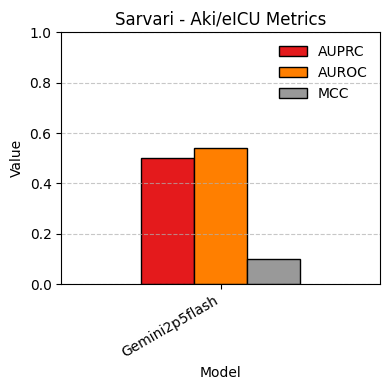

In [113]:
plot_metrics(df_gemini2p5_metrics.iloc[[1], :], "Sarvari - Aki/eICU ")